In [80]:
# TODO
#
# [ ] Use cached .png images instead of downloading from the web and converting to png

from IPython.display import SVG, display, Image
from cairo import Context, SVGSurface, ImageSurface

DISP_WIDTH = 512
DISP_HEIGHT = 256

# Display image in jupyter
def show_img(file):
    display(Image(filename=file))
    
def show_svg(file):
    display(SVG(filename=file))

# Decorator to display any cairo drawing. Saves result at tmp/example.svg and then shows.
def disp(*args, width = DISP_WIDTH, height = DISP_HEIGHT, **kwargs):
    def decorator_func(draw_func):
        with SVGSurface("tmp/tmp.svg", width, height) as surface:
            ctx = Context(surface)
            
            # border
            ctx.set_source_rgba(0, 0, 0, 1)
            ctx.rectangle(0, 0, width, height)
            ctx.set_line_width(2 * 0.002 * width)
            ctx.stroke()
            ctx.scale(width, height)
            
            draw_func(ctx, *args, **kwargs)
        show_svg("tmp/tmp.svg")
    return decorator_func

564 846


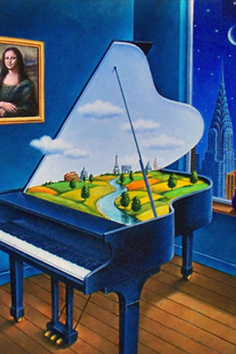

In [87]:
from game import Card
from urllib.request import urlopen
from PIL import Image

@disp(width=236, height=354, card=Card(image_id=16, _id=1))
def draw_card(ctx, card):
    file_jpeg = urlopen(card.url)
    pil_file_jpeg = Image.open(file_jpeg)
    png_filename = f'tmp/card_{card.image_id:0>5}.png'
    pil_file_jpeg.save(png_filename)
    card_surface = ImageSurface.create_from_png(png_filename)
    print(card_surface.get_width(), card_surface.get_height())
    
    ctx.scale(1/card_surface.get_width(), 1/card_surface.get_height())
    ctx.set_source_surface(card_surface, 0, 0)
    ctx.paint()
    
@disp(width=512, height=512)
def draw_profile_pic(ctx, pic):
    # Assuming pic is a png
    # Ref: https://python-telegram-bot.readthedocs.io/en/stable/telegram.bot.html?highlight=getuserprofile#telegram.Bot.get_user_profile_photos
    # bot.get_user_profile_photos(user_id, ...) --returns--> UserProfilePhotos --.photos[0][0]--> PhotoSize --.get_file()--> File --download(custom_path)--> Baixou o arquivo finalmente
    return 